In [1]:
pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.5 MB 29.3 MB/s 
     |████████████████████████████████| 1.0 MB 50.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyvi import ViTokenizer, ViPosTagger # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP
import os
import pickle

In [4]:
from keras import Input
from keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dropout

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

In [5]:
X_data = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/27Topics/X_data.pkl', 'rb'))
y_data = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/27Topics/y_data.pkl', 'rb'))

X_test = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/27Topics/X_test.pkl', 'rb'))
y_test = pickle.load(open('/content/drive/MyDrive/Python/CS431/data/27Topics/y_test.pkl', 'rb'))



In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)
tfidf_vect.fit(X_data) # learn vocabulary and idf from training set
X_data_tfidf =  tfidf_vect.transform(X_data)
# assume that we don't have test set before
X_test_tfidf =  tfidf_vect.transform(X_test)

In [7]:
tfidf_vect.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aaa',
 'aac',
 'aachen',
 'aaron',
 'aas',
 'ab',
 'abacus',
 'abayern',
 'abba',
 'abbey',
 'abbiati',
 'abbiatti',
 'abbondanzieri',
 'abbott',
 'abby',
 'abc',
 'abdalla',
 'abdallaa',
 'abdev',
 'abdoulaye',
 'abdul',
 'abdullah',
 'abe',
 'abedi',
 'abeijon',
 'abel',
 'abella',
 'aberystwyth',
 'abey',
 'abeyie',
 'abf',
 'abidal',
 'abigail',
 'abilass',
 'abn',
 'about',
 'above',
 'abraham',
 'abramovich',
 'ac',
 'academic',
 'academy',
 'acapella',
 'acapulco',
 'acasuso',
 'acb',
 'acbs',
 'acc',
 'acca',
 'accelerator',
 'accept',
 'access',
 'accor',
 'account',
 'accreditation',
 'accu',
 'ace',
 'aceh',
 'acer',
 'acet',
 'acetone',
 'acfta',
 'ach',
 'achilefu',
 'achilles',
 'achiri',
 'acht',
 'achuta',
 'acid',
 'acid_amin',
 'acid_béo',
 'acimovic',
 'ackermann',
 'acm',
 'acn',
 'acnp',
 'acoo',
 'acosta',
 'acoustic',
 'acpe',
 'acquaviva',
 'acrobat',
 'acrylic',
 'act',
 'action',
 'active',
 'activex',
 'activision',
 'activities',
 'acura',
 'acyclov

In [8]:
from sklearn.decomposition import TruncatedSVD

In [9]:
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_data_tfidf)

TruncatedSVD(n_components=300, random_state=42)

In [10]:
X_data_tfidf_svd = svd.transform(X_data_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

In [11]:
from sklearn import preprocessing, metrics
encoder = preprocessing.LabelEncoder()
y_data_n = encoder.fit_transform(y_data)
y_test_n = encoder.fit_transform(y_test)

encoder.classes_

array(['Am nhac', 'Am thuc', 'Bat dong san', 'Bong da', 'Chung khoan',
       'Cum ga', 'Cuoc song do day', 'Du hoc', 'Du lich', 'Duong vao WTO',
       'Gia dinh', 'Giai tri tin hoc', 'Giao duc', 'Gioi tinh',
       'Hackers va Virus', 'Hinh su', 'Khong gian song',
       'Kinh doanh quoc te', 'Lam dep', 'Loi song', 'Mua sam', 'My thuat',
       'San khau dien anh', 'San pham tin hoc moi', 'Tennis',
       'The gioi tre', 'Thoi trang'], dtype='<U20')

In [12]:
def plot_model_history(model_history, acc='accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
    axs[0].legend(['train'], loc='best')
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train'], loc='best')
    plt.show()

In [13]:
epochs=100
learning_rate=0.001

In [14]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.9)

In [16]:
adam = Adam(learning_rate=lr_schedule)
sgd = SGD(learning_rate=lr_schedule)

In [17]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve, classification_report, auc

In [18]:
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True, fmt='g')
    print(cmx_data)
    plt.show()

In [19]:
def create_dnn_model():
    input_layer = Input(shape=(300,))
    layer = Dense(1024, activation='relu')(input_layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = Dropout(0.4)(layer)
    output_layer = Dense(27, activation='softmax')(layer)
    classifier = Model(input_layer, output_layer)
    classifier.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return classifier

In [20]:
def train_model(classifier, X_data, y_data, X_test, y_test, is_neuralnet=False, epochs=epochs):       
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
    
    model_history = classifier.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32,callbacks=[earlystopping])
    
    val_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(X_test)
    val_predictions = val_predictions.argmax(axis=-1)
    test_predictions = test_predictions.argmax(axis=-1)
        
    print("Validation accuracy: ", metrics.accuracy_score(val_predictions, y_val))
    print("Test accuracy: ", metrics.accuracy_score(test_predictions, y_test))
    plot_model_history(model_history)
    
    target_names = ["Class {}".format(i) for i in range(27)]
    print(classification_report(test_predictions, y_test, target_names=target_names, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]))
    print_cmx(test_predictions, y_test)

In [21]:
classifier=create_dnn_model()

Epoch 1/100
405/405 [==============================] - 4s 4ms/step - loss: 0.6123 - accuracy: 0.8389 - val_loss: 0.7796 - val_accuracy: 0.8421
Epoch 2/100
405/405 [==============================] - 1s 4ms/step - loss: 0.3737 - accuracy: 0.8940 - val_loss: 0.4373 - val_accuracy: 0.8741
Epoch 3/100
405/405 [==============================] - 1s 4ms/step - loss: 0.3431 - accuracy: 0.9003 - val_loss: 0.3874 - val_accuracy: 0.8804
Epoch 4/100
405/405 [==============================] - 1s 4ms/step - loss: 0.3233 - accuracy: 0.9030 - val_loss: 0.8858 - val_accuracy: 0.7483
Epoch 5/100
405/405 [==============================] - 1s 4ms/step - loss: 0.3142 - accuracy: 0.9065 - val_loss: 0.3916 - val_accuracy: 0.8908
Epoch 6/100
405/405 [==============================] - 2s 4ms/step - loss: 0.3173 - accuracy: 0.9072 - val_loss: 0.4180 - val_accuracy: 0.8818
Epoch 7/100
405/405 [==============================] - 1s 4ms/step - loss: 0.2888 - accuracy: 0.9099 - val_loss: 0.4218 - val_accuracy: 0.8811

<ipython-input-12-54089400f08a>:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1, len(model_history.history[acc]) + 1), len(model_history.history[acc]) / 10)
<ipython-input-12-54089400f08a>:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)


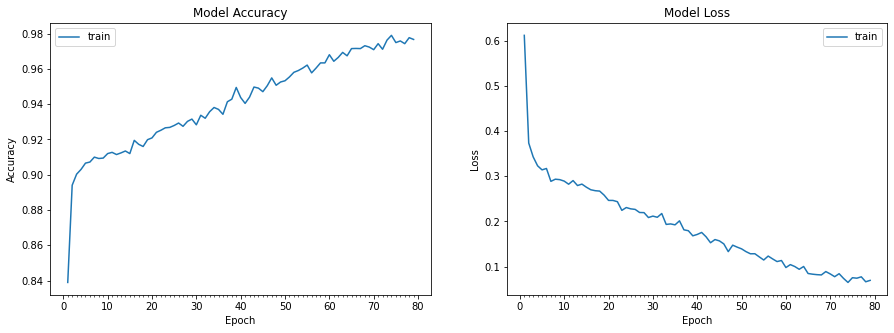

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:2126: UserWarning: labels size, 28, does not match size of target_names, 27
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Class 0       0.93      0.94      0.94       396
     Class 1       0.90      1.00      0.95       253
     Class 2       0.99      0.99      0.99      1461
     Class 3       0.95      0.98      0.97       310
     Class 4       0.99      0.99      0.99       380
     Class 5       0.56      0.83      0.67       272
     Class 6       0.90      0.94      0.92       377
     Class 7       0.95      0.84      0.89       643
     Class 8       0.81      0.99      0.89       156
     Class 9       0.48      0.83      0.61       163
    Class 10       0.83      0.76      0.79       780
    Class 11       0.83      0.94      0.88       625
    Class 12       0.69      0.95      0.80       196
    Class 13       0.85      0.96      0.90       281
    Class 14       0.82      0.98      0.89       164
    Class 15       0.95      0.80      0.87        69
    Class 16       0.92      0.87      0.89       589
    Class 17       0.95    

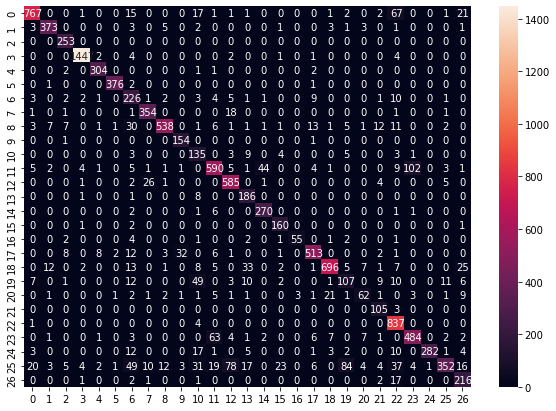

In [22]:
train_model(classifier=classifier, X_data=X_data_tfidf_svd, y_data=y_data_n, X_test=X_test_tfidf_svd, y_test=y_test_n)